<a href="https://colab.research.google.com/github/SYongho/Estimated-LH-PG-in-horizontal-pipe/blob/Ensemble/Ensemble_with_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
 
!pip install catboost
import catboost as cb
from catboost import CatBoostRegressor

## Data

In [ ]:
csv_inp = pd.read_csv('ins.csv')
csv_out = pd.read_csv('outs.csv')
train_inp, test_inp, train_out, test_out = train_test_split(csv_inp, csv_out, test_size=0.2, random_state=38)

test_inp = test_inp.reset_index(drop=True)
test_out = test_out.reset_index(drop=True)

In [ ]:
pp_data = pd.read_csv('prepared_data.csv')
inputs = pd.DataFrame(pp_data.iloc[:, [7,4,1,8,5]])
inputs.columns = train_inp.columns
outputs = pp_data.iloc[:, 10:]
outputs.columns = train_out.columns
tr_inp, te_inp, tr_out, te_out = train_test_split(inputs, outputs, test_size=0.2, random_state=38)

te_inp = te_inp.reset_index(drop=True)
te_out = te_out.reset_index(drop=True)

### efefef

In [2]:
test_inp = pd.read_csv('ins.csv')
test_out = pd.read_csv('outs.csv')

clean_data = pd.read_csv('clean_data.csv')
train_inp = clean_data.iloc[:, :5]
train_out = clean_data.iloc[:, 5:]
train_inp, val_inp, train_out, val_out = train_test_split(train_inp, train_out, test_size=0.2, random_state=38)

val_inp = val_inp.reset_index(drop=True)
val_out = val_out.reset_index(drop=True)

## Model Class

In [3]:
class ML_for_LH_PG():
  def __init__(self):
    self.val_inp = val_inp
    self.val_out = val_out
    self.val_out_LH = pd.DataFrame(self.val_out.iloc[:,0].reset_index(drop=True))
    self.val_out_PG = pd.DataFrame(self.val_out.iloc[:,1].reset_index(drop=True))

    self.train_inp = train_inp
    self.train_out = train_out
    self.train_out_LH = pd.DataFrame(self.train_out.iloc[:,0].reset_index(drop=True))
    self.train_out_PG = pd.DataFrame(self.train_out.iloc[:,1].reset_index(drop=True))

  def RMSE(self, targets, predictions):
    return np.sqrt(np.mean(np.square(targets-predictions)))

  def MAPE(self, targets, predictions):
    return np.mean(np.abs((targets-predictions)) / targets) * 100

  def MSE(self, targets, predictions):
    return np.mean(np.square(targets-predictions))

  def test_Error(self, test_out, col_1, col_2):
    test_out = test_out.reset_index(drop=True)
    test_out_LH = pd.DataFrame(test_out.iloc[:,0])
    test_out_PG = pd.DataFrame(test_out.iloc[:,1])

    df = [self.RMSE(test_out_LH, col_1)[0], self.RMSE(test_out_PG, col_2)[0],
          self.MAPE(test_out_LH, col_1)[0], self.MAPE(test_out_PG, col_2)[0],
          self.MSE(test_out_LH, col_1)[0], self.MSE(test_out_PG, col_2)[0],
          metrics.r2_score(test_out_LH, col_1), metrics.r2_score(test_out_PG, col_2)]
    error_col = ['pred_LH RMSE', 'pred_PG RMSE', 'pred_LH MAPE', 'pred_PG MAPE', 'pred_LH MSE', 'pred_PG MSE', 'LH_R2 score', 'PG_R2 score']
    return pd.DataFrame([df], columns=error_col)


  def RF(self, test_inp):
    model_RF = RandomForestRegressor(n_estimators=300, max_depth = 20)
    fit = model_RF.fit(self.train_inp, self.train_out_LH)
    test_pred_LH = pd.DataFrame(fit.predict(test_inp), columns=self.train_out_LH.columns)
    
    model_RF = RandomForestRegressor(n_estimators=300, max_depth = 20)
    fit = model_RF.fit(self.train_inp, self.train_out_PG)
    test_pred_PG = pd.DataFrame(fit.predict(test_inp), columns=self.train_out_PG.columns)
    return test_pred_LH, test_pred_PG

  def AdaB(self, test_inp):
    tree_model = DecisionTreeRegressor(max_depth=20)
    model_ADB = AdaBoostRegressor(base_estimator=tree_model, n_estimators=300)
    fit = model_ADB.fit(self.train_inp, self.train_out_LH)
    test_pred_LH = pd.DataFrame(fit.predict(test_inp), columns=self.train_out_LH.columns)

    tree_model = DecisionTreeRegressor(max_depth=20)
    model_ADB = AdaBoostRegressor(base_estimator=tree_model, n_estimators=300)
    fit = model_ADB.fit(self.train_inp, self.train_out_PG)
    test_pred_PG = pd.DataFrame(fit.predict(test_inp), columns=self.train_out_PG.columns)
    return test_pred_LH, test_pred_PG

  def XGBReg(self, test_inp):
    xgb_train = xgb.DMatrix(data=self.train_inp, label=self.train_out_LH)
    xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=32, learning_rate=0.03, objective='reg:squarederror',
                                 reg_lambda=1.5, reg_alpha=0.5, early_stopping_round=5)
    fit = xgb_model.fit(self.train_inp, self.train_out_LH, eval_set=[(self.val_inp, self.val_out_LH)], verbose=False)
    test_pred_LH = pd.DataFrame(fit.predict(test_inp), columns=self.train_out_LH.columns)

    xgb_train = xgb.DMatrix(data=self.train_inp, label=self.train_out_PG)
    xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=32, learning_rate=0.03, objective='reg:squarederror',
                                 reg_lambda=1.5, reg_alpha=0.5, early_stopping_round=5)
    fit = xgb_model.fit(self.train_inp, self.train_out_PG, eval_set=[(self.val_inp, self.val_out_PG)], verbose=False)
    test_pred_PG = pd.DataFrame(fit.predict(test_inp), columns=self.train_out_PG.columns)
    return test_pred_LH, test_pred_PG

  def LGBM(self, test_inp):
    lgb_train = lgb.Dataset(data=self.train_inp, label=self.train_out_LH)
    lgb_param = {'max_depth': 20,
                'learning_rate': 0.01,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'random_state':38}
    lgb_model = lgb.train(params=lgb_param, train_set=lgb_train, num_boost_round=500)
    test_pred_LH = pd.DataFrame(lgb_model.predict(test_inp), columns=self.train_out_LH.columns)

    lgb_train = lgb.Dataset(data=self.train_inp, label=self.train_out_PG)
    lgb_param = {'max_depth': 20,
                'learning_rate': 0.01,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'random_state':38}
    lgb_model = lgb.train(params=lgb_param, train_set=lgb_train, num_boost_round=500)
    test_pred_PG = pd.DataFrame(lgb_model.predict(test_inp), columns=self.train_out_PG.columns)
    return test_pred_LH, test_pred_PG

  def CB(self, test_inp):
    train_inp, val_inp, train_out, val_out = train_test_split(self.train_inp, self.train_out, test_size=0.11, random_state=38)
    train_out_LH = pd.DataFrame(train_out.iloc[:,0].reset_index(drop=True))
    train_out_PG = pd.DataFrame(train_out.iloc[:,1].reset_index(drop=True))
    val_out_LH = pd.DataFrame(val_out.iloc[:,0].reset_index(drop=True))
    val_out_PG = pd.DataFrame(val_out.iloc[:,1].reset_index(drop=True))

    cb_train = cb.Pool(data=train_inp, label=train_out_LH)
    cb_model = CatBoostRegressor(n_estimators=10, max_depth=16, 
                                learning_rate=0.01, loss_function='MAE', eval_metric='RMSE')
    cb_model.fit(cb_train, use_best_model=True, eval_set=(val_inp, val_out_LH), silent=True, plot=True)
    test_pred_LH = pd.DataFrame(cb_model.predict(test_inp), columns=self.train_out_LH.columns)

    cb_train = cb.Pool(data=self.train_inp, label=self.train_out_PG)
    cb_model = CatBoostRegressor(n_estimators=10, max_depth=16, 
                                learning_rate=0.01, loss_function='MAE', eval_metric='RMSE')
    cb_model.fit(cb_train, use_best_model=True, eval_set=(val_inp, val_out_PG), silent=True, plot=True)
    test_pred_PG = pd.DataFrame(cb_model.predict(test_inp), columns=self.train_out_PG.columns)
    return test_pred_LH, test_pred_PG

  def Ens_Ens_XGBReg(self, test_inp):
    bagging_predict_result_LH = []
    for _ in range(10):
      data_index = [data_index for data_index in range(self.train_inp.shape[0])]
      random_data_index = np.random.choice(data_index, self.train_inp.shape[0])

      xgb_train = xgb.DMatrix(data=self.train_inp, label=self.train_out_LH)
      xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=32, learning_rate=0.03, objective='reg:squarederror',
                                 reg_lambda=1.5, reg_alpha=0.5, early_stopping_round=5)
      fit = xgb_model.fit(self.train_inp, self.train_out_LH)
      predict1_LH = fit.predict(test_inp)
      bagging_predict_result_LH.append(predict1_LH)

    bagging_predict_LH = []
    for lst2_index in range(test_inp.shape[0]):
      temp_predict_LH = []
      for lst_index in range(len(bagging_predict_result_LH)):
        temp_predict_LH.append(bagging_predict_result_LH[lst_index][lst2_index])
      bagging_predict_LH.append(np.mean(temp_predict_LH))
    test_pred_LH = pd.DataFrame(bagging_predict_LH, columns=self.train_out_LH.columns)

    bagging_predict_result_PG = []
    for _ in range(10):
      data_index = [data_index for data_index in range(self.train_inp.shape[0])]
      random_data_index = np.random.choice(data_index, self.train_inp.shape[0])

      xgb_train = xgb.DMatrix(data=self.train_inp, label=self.train_out_PG)
      xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=32, learning_rate=0.03, objective='reg:squarederror',
                                 reg_lambda=1.5, reg_alpha=0.5, early_stopping_round=5)
      fit = xgb_model.fit(self.train_inp, self.train_out_PG)
      predict1_PG = fit.predict(test_inp)
      bagging_predict_result_PG.append(predict1_PG)

    bagging_predict_PG = []
    for lst2_index in range(test_inp.shape[0]):
      temp_predict_PG = []
      for lst_index in range(len(bagging_predict_result_PG)):
        temp_predict_PG.append(bagging_predict_result_PG[lst_index][lst2_index])
      bagging_predict_PG.append(np.mean(temp_predict_PG))
    test_pred_PG = pd.DataFrame(bagging_predict_PG, columns=self.train_out_PG.columns)
    return test_pred_LH, test_pred_PG
#------------------------------------------------------------------------------------------#
  def Ens_Ens_LGBM(self, test_inp):
    bagging_predict_result_LH = []
    for _ in range(10):
      data_index = [data_index for data_index in range(self.train_inp.shape[0])]
      random_data_index = np.random.choice(data_index, self.train_inp.shape[0])

      lgb_train = lgb.Dataset(data=self.train_inp.iloc[random_data_index,], label=self.train_out_LH.iloc[random_data_index,])
      lgb_param = {'max_depth': 30,
                  'n_estimators': 500,
                  'learning_rate': 0.01,
                  'boosting_type': 'gbdt',
                  'objective': 'regression'}
      lgb_model = lgb.train(params=lgb_param, train_set=lgb_train)
      predict1_LH = lgb_model.predict(test_inp)
      bagging_predict_result_LH.append(predict1_LH)

    bagging_predict_LH = []
    for lst2_index in range(test_inp.shape[0]):
      temp_predict_LH = []
      for lst_index in range(len(bagging_predict_result_LH)):
        temp_predict_LH.append(bagging_predict_result_LH[lst_index][lst2_index])
      bagging_predict_LH.append(np.mean(temp_predict_LH))
    test_pred_LH = pd.DataFrame(bagging_predict_LH, columns=self.train_out_LH.columns)

    bagging_predict_result_PG = []
    for _ in range(10):
      data_index = [data_index for data_index in range(self.train_inp.shape[0])]
      random_data_index = np.random.choice(data_index, self.train_inp.shape[0])

      lgb_train = lgb.Dataset(data=self.train_inp.iloc[random_data_index,], label=self.train_out_PG.iloc[random_data_index,])
      lgb_param = {'max_depth': 30,
                  'n_estimators': 500,
                  'learning_rate': 0.01,
                  'boosting_type': 'gbdt',
                  'objective': 'regression'}
      lgb_model = lgb.train(params=lgb_param, train_set=lgb_train)
      predict1_PG = lgb_model.predict(test_inp)
      bagging_predict_result_PG.append(predict1_PG)

    bagging_predict_PG = []
    for lst2_index in range(test_inp.shape[0]):
      temp_predict_PG = []
      for lst_index in range(len(bagging_predict_result_PG)):
        temp_predict_PG.append(bagging_predict_result_PG[lst_index][lst2_index])
      bagging_predict_PG.append(np.mean(temp_predict_PG))
    test_pred_PG = pd.DataFrame(bagging_predict_PG, columns=self.train_out_PG.columns)
    return test_pred_LH, test_pred_PG
#------------------------------------------------------------------------------------------#
  def Ens_Ens_Mul(self, test_inp):
    bagging_predict_result_LH = []
    for _ in range(5):
      data_index = [data_index for data_index in range(self.train_inp.shape[0])]
      random_data_index = np.random.choice(data_index, self.train_inp.shape[0])

      xgb_train = xgb.DMatrix(data=self.train_inp, label=self.train_out_LH)
      xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=32, learning_rate=0.03, objective='reg:squarederror',
                                 reg_lambda=1.5, reg_alpha=0.5, early_stopping_round=5)
      fit = xgb_model.fit(self.train_inp, self.train_out_LH, eval_set=[(self.val_inp, self.val_out_LH)], verbose=False)
      predict1_LH = fit.predict(test_inp)
      bagging_predict_result_LH.append(predict1_LH)

      lgb_train = lgb.Dataset(data=self.train_inp.iloc[random_data_index,], label=self.train_out_LH.iloc[random_data_index,])
      lgb_param = {'max_depth': 30,
                  'n_estimators': 500,
                  'learning_rate': 0.01,
                  'boosting_type': 'gbdt',
                  'objective': 'regression'}
      lgb_model = lgb.train(params=lgb_param, train_set=lgb_train)
      predict1_LH = lgb_model.predict(test_inp)
      bagging_predict_result_LH.append(predict1_LH)

      tree_model = DecisionTreeRegressor(max_depth=20)
      Ada_model = AdaBoostRegressor(base_estimator=tree_model, n_estimators=300)
      Ada_model.fit(self.train_inp, self.train_out_LH)
      Ada_predict_LH = Ada_model.predict(test_inp)
      bagging_predict_result_LH.append(Ada_predict_LH)

    bagging_predict_LH = []
    for lst2_index in range(test_inp.shape[0]):
      temp_predict_LH = []
      for lst_index in range(len(bagging_predict_result_LH)):
        temp_predict_LH.append(bagging_predict_result_LH[lst_index][lst2_index])
      bagging_predict_LH.append(np.mean(temp_predict_LH))
    test_pred_LH = pd.DataFrame(bagging_predict_LH, columns=self.train_out_LH.columns)

    bagging_predict_result_PG = []
    for _ in range(5):
      data_index = [data_index for data_index in range(self.train_inp.shape[0])]
      random_data_index = np.random.choice(data_index, self.train_inp.shape[0])

      xgb_train = xgb.DMatrix(data=self.train_inp, label=self.train_out_PG)
      xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=32, learning_rate=0.03, objective='reg:squarederror',
                                 reg_lambda=1.5, reg_alpha=0.5, early_stopping_round=5)
      fit = xgb_model.fit(self.train_inp, self.train_out_PG, eval_set=[(self.val_inp, self.val_out_PG)], verbose=False)
      predict1_PG = fit.predict(test_inp)
      bagging_predict_result_PG.append(predict1_PG)

      lgb_train = lgb.Dataset(data=self.train_inp.iloc[random_data_index,], label=self.train_out_PG.iloc[random_data_index,])
      lgb_param = {'max_depth': 30,
                  'n_estimators': 500,
                  'learning_rate': 0.01,
                  'boosting_type': 'gbdt',
                  'objective': 'regression'}
      lgb_model = lgb.train(params=lgb_param, train_set=lgb_train)
      predict1_PG = lgb_model.predict(test_inp)
      bagging_predict_result_PG.append(predict1_PG)

      tree_model = DecisionTreeRegressor(max_depth=20)
      Ada_model = AdaBoostRegressor(base_estimator=tree_model, n_estimators=300)
      Ada_model.fit(self.train_inp, self.train_out_PG)
      Ada_predict_PG = Ada_model.predict(test_inp)
      bagging_predict_result_PG.append(Ada_predict_PG)

    bagging_predict_PG = []
    for lst2_index in range(test_inp.shape[0]):
      temp_predict_PG = []
      for lst_index in range(len(bagging_predict_result_PG)):
        temp_predict_PG.append(bagging_predict_result_PG[lst_index][lst2_index])
      bagging_predict_PG.append(np.mean(temp_predict_PG))

    test_pred_PG = pd.DataFrame(bagging_predict_PG, columns=self.train_out_PG.columns)
    return test_pred_LH, test_pred_PG

## Predict and Error Check

In [4]:
ml = ML_for_LH_PG()
pred = ml.Ens_Ens_XGBReg(test_inp)

* pred[0] : predicted LH
* pred[1] : predicted PG

In [5]:
ml.test_Error(test_out, pred[0], pred[1])

,pred_LH RMSE,pred_PG RMSE,pred_LH MAPE,pred_PG MAPE,pred_LH MSE,pred_PG MSE,LH_R2 score,PG_R2 score
0,0.080443,781.845698,6.197787,12.500187,0.006471,611282.695213,0.754735,0.953162


Adaboost나 LightGBM 하이퍼파라미터 손보기

## Plot Class

In [6]:
class Plots(ML_for_LH_PG):
  def __init__(self):
    super().__init__()

  def plot_col_1(self, targets, predictions):
    plt.scatter(targets, predictions, c='k', s=1.8)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('square')
    plt.xlim([0,1])
    plt.ylim([0,1])
    _ = plt.plot([-100,100], [-100,100])
    return pd.concat([targets, predictions], axis=1)

  def plot_col_2(self, targets, predictions):
    plt.scatter(targets, predictions, c='k', s=1.8)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('square')
    plt.xlim([0, targets.max()-(targets.max()%10)+1000])
    plt.ylim([0, targets.max()-(targets.max()%10)+1000])
    _ = plt.plot([-20000,20000], [-20000,20000])
    return pd.concat([targets, predictions], axis=1)

,Liquid holdup,Liquid holdup
0,0.55,0.593999
1,0.59,0.605766
2,0.23,0.252796
3,0.53,0.546584
4,0.38,0.414588
...,...,...
345,0.75,0.772183
346,0.60,0.614241
347,0.81,0.823093
348,0.70,0.711541


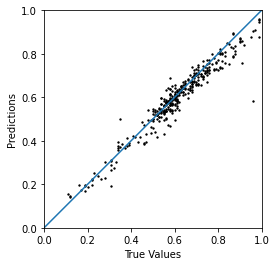

In [7]:
Plot = Plots()
LH = Plot.plot_col_1(test_out['Liquid holdup'], pred[0])
LH

,Pressure gradient,Pressure gradient
0,369,399.947662
1,775,769.499939
2,2634,2867.525879
3,1002,1001.854309
4,224,216.938141
...,...,...
345,2579,2579.208740
346,2917,2917.001465
347,1044,850.679871
348,2666,2668.969238


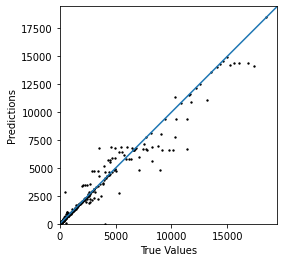

In [8]:
PG = Plot.plot_col_2(test_out['Pressure gradient'], pred[1])
PG